<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/MEGprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setting up the Colab page to use neqsim
%%capture
!pip install git+https://github.com/equinor/neqsim-python.git
#!pip install neqsim==3.0.19
import neqsim
from neqsim.thermo.thermoTools import *

# MEG for hydrate inhibition and regeneration of MEG

**Introduction**

Monoethylene glycol (MEG) is commonly used in the oil and gas industry for hydrate inhibition in pipelines and process equipment. This process involves injecting MEG into the gas stream to prevent hydrate formation. After use, the MEG is regenerated to remove water and maintain its effectiveness. This notebook explores the principles of MEG for hydrate inhibition and regeneration, including:

* **Hydrate Formation:** Understanding the conditions that lead to hydrate formation in natural gas systems.
* **MEG Inhibition:** How MEG prevents hydrate formation by lowering the hydrate formation temperature.
* **MEG Regeneration:** Methods for removing water from MEG to restore its hydrate inhibition properties.
* **Case Studies:** Examples of MEG applications in real-world scenarios.

# Litterature

Wikipedia

https://en.wikipedia.org/wiki/Ethylene_glycol


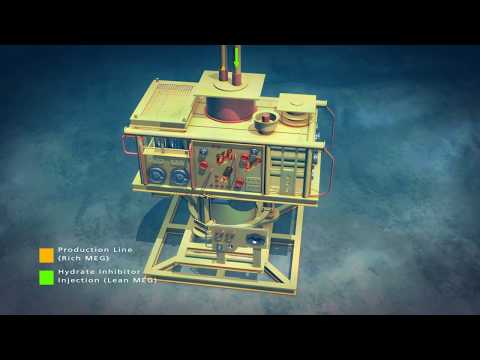

In [2]:
#@title MEG reclamation
#@markdown This video gives an intriduction to MEG reclamation
from IPython.display import YouTubeVideo
YouTubeVideo('4HosHcGvtVM', width=600, height=400)

# Simulation fo MEG regeneration

In [ ]:
from neqsim.process import stream, clearProcess
from neqsim.thermo.thermoTools import fluid, TPflash
from neqsim import jneqsim as neqsim
from neqsim.thermo import thermodynamicoperations

# -----------------------------------------------------------------------------
# 1) Create fluid (equivalent to new SystemSrkCPAstatoil(273.15 + 40, 6.0))
# -----------------------------------------------------------------------------
fluid1 = fluid('cpa', temperature=273.15 + 40.0, pressure=6.0)

# 2) Add components
fluid1.addComponent("nitrogen", 0.1)
fluid1.addComponent("CO2", 0.05)
fluid1.addComponent("methane", 9.0)
fluid1.addComponent("ethane", 0.5)
fluid1.addComponent("propane", 0.3)
fluid1.addComponent("water", 75.0)
fluid1.addComponent("MEG", 25.0)

# 3) Set mixing rule
fluid1.setMixingRule(10)  # 10 => classic CPA mixing rule

# 4) Perform a TP flash
TPflash(fluid1)

# 5) Extract phases as separate SystemInterfaces
#    phaseToSystem(0) => likely the gas phase
#    phaseToSystem(1) => likely the liquid phase
feedGas = fluid1.phaseToSystem(0)
feedMEG = fluid1.phaseToSystem(1)

# 6) Calculate weight fraction of MEG in the second phase
wtMEG = feedMEG.getPhase(0).getWtFrac("MEG") * 100.0

clearProcess()
# -----------------------------------------------------------------------------
# 7) Create process streams
# -----------------------------------------------------------------------------
stream1 = stream("stream 1", feedMEG)
stream1.setFlowRate(6000.0, "kg/hr")
stream1.setTemperature(80.0, "C")
stream1.setPressure(1.021, "bara")
stream1.run()

stripgas = stream("stream 2", feedGas)
stripgas.setFlowRate(10.0, "kg/hr")
stripgas.setTemperature(80.0, "C")
stripgas.setPressure(1.021, "bara")
stripgas.run()

# -----------------------------------------------------------------------------
# 8) Create and configure the distillation column
# -----------------------------------------------------------------------------
distillationColumn = neqsim.process.equipment.distillation.DistillationColumn("MEG column", 2, True, True)
distillationColumn.addFeedStream(stream1, 1)
distillationColumn.addFeedStream(stripgas, 1)

distillationColumn.getReboiler().setOutTemperature(273.15 + 140.0)  # 140 C
distillationColumn.getCondenser().setOutTemperature(273.15 + 35.0)  # 35 C

distillationColumn.setTopPressure(1.021)
distillationColumn.setBottomPressure(1.021)

# enable separation with liquid reflux => 370.0 kg/hr reflux flow
distillationColumn.getCondenser().setSeparation_with_liquid_reflux(True,
                                                                   370.0,
                                                                   "kg/hr")
# 9) Run the column simulation
distillationColumn.run()


In [ ]:
print(f"""
---------- PROCESS RESULTS ----------
density feed: {wtMEG} kg/m3
Distillation column top gas flow: {distillationColumn.getGasOutStream().getFlowRate('kg/hr')} kg/hr
Distillation column top temperature: {distillationColumn.getGasOutStream().getTemperature('C')} °C
Distillation column bottom liquid flow: {distillationColumn.getLiquidOutStream().getFlowRate('kg/hr')} kg/hr
Split to water treatment: {distillationColumn.getCondenser().getLiquidProductStream().getFlowRate('kg/hr')} kg/hr
Split to recycle to column: {distillationColumn.getCondenser().getLiquidOutStream().getFlowRate('kg/hr')} kg/hr
wt% MEG to treatment: {distillationColumn.getCondenser().getLiquidProductStream().getFluid().getPhase(0).getWtFrac('MEG') * 100.0} wt%
flow MEG to treatment: {distillationColumn.getCondenser().getLiquidProductStream().getFluid().getComponent('MEG').getFlowRate('kg/hr')} kg/hr
density reflux: {distillationColumn.getCondenser().getLiquidProductStream().getFluid().getDensity('kg/m3')} kg/m3
wt% MEG in bottom: {distillationColumn.getLiquidOutStream().getFluid().getPhase(0).getWtFrac('MEG') * 100.0} wt%
KOF: {distillationColumn.getCondenser().getLiquidProductStream().getFluid().getPhase(0).getWtFrac('MEG') * 1.0e6 / 1.547} KOF
Reboiler duty: {distillationColumn.getReboiler().getDuty() / 1.0e6} MW
Condenser duty: {distillationColumn.getCondenser().getDuty() / 1.0e6} MW
Condenser temperature: {distillationColumn.getCondenser().getTemperature()} °C
Tray 1 temperature: {distillationColumn.getTray(1).getTemperature()} °C
Tray 2 temperature: {distillationColumn.getTray(2).getTemperature()} °C
""".strip())

# Printing streams

In [ ]:
printFrame(distillationColumn.getCondenser().getFluid())
printFrame(distillationColumn.getReboiler().getFluid())

# Evaluation of reboiler temperature

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

temperatures = np.linspace(120, 250, 10)  # Create 10 temperature points between 120 and 150°C

# Create lists to store the variables:
flow_to_treatment = []
flow_MEG_to_treatment = []
wt_MEG_to_treatment = []
temperature_top_column = []
reboiler_duty = []
cooler_duty = []

# Iterate through the temperature range:
for temp in temperatures:
    splitter1.setFlowRates([temp, -1], 'kg/hr')
    pro1.run()

    # Append the calculated values to the lists:
    flow_to_treatment.append(pro1.getUnit('to treatment').getFlowRate('kg/hr'))
    flow_MEG_to_treatment.append(pro1.getUnit('to treatment').getFluid().getComponent('MEG').getFlowRate('kg/hr'))
    wt_MEG_to_treatment.append(pro1.getUnit('to treatment').getFluid().getPhase(0).getWtFrac('MEG')*100)
    reboiler_duty.append(distillationColumn.getReboiler().getDuty()/1e6)
    cooler_duty.append(cooler.getDuty()/1e6)
    temperature_top_column.append(distillationColumn.getGasOutStream().getTemperature('C'))

# Plotting the results:
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(temperatures, flow_to_treatment)
plt.title('Flow to Treatment')
plt.xlabel('Temperature (°C)')
plt.ylabel('Flow (kg/hr)')

plt.subplot(2, 2, 2)
plt.plot(temperatures, flow_MEG_to_treatment)
plt.title('Flow MEG to Treatment')
plt.xlabel('Temperature (°C)')
plt.ylabel('Flow (kg/hr)')

plt.subplot(2, 2, 3)
plt.plot(temperatures, wt_MEG_to_treatment)
plt.title('wt% MEG to Treatment')
plt.xlabel('Temperature (°C)')
plt.ylabel('wt%')

plt.subplot(2, 2, 4)
plt.plot(temperatures, reboiler_duty)
plt.title('Reboiler Duty')
plt.xlabel('Temperature (°C)')
plt.ylabel('Duty (MW)')

#Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


plt.figure(figsize=(5,3))
plt.plot(temperatures, cooler_duty)
plt.title('Cooler Duty')
plt.xlabel('Temperature (°C)')
plt.ylabel('Duty (MW)')
plt.show()

plt.figure(figsize=(5,3))
plt.plot(temperatures, temperature_top_column)
plt.title('temperature_top_column')
plt.xlabel('Temperature (°C)')
plt.ylabel('temperature_top_column (C)')
plt.show()